In [1]:
cd C:\Users\Nicole\Desktop\31008DMP\dataset

C:\Users\Nicole\Desktop\31008DMP\dataset


In [2]:
import random
import numpy as np
import pandas as pd
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
raw_df = pd.read_csv('data_final_popularity.csv')
raw_df.shape

(234372, 49)

In [4]:
col_to_exclude = ['artist_song_id', 'artists', 'artist_name', 'id', 'name', 'year']
col_to_dummy = ['period', 'num_artists_grp']
target_var = 'popularity_target'

In [5]:
raw_df.select_dtypes(include=['object']).columns

Index(['artists', 'id', 'name', 'artist_name', 'num_artists_grp', 'period',
       'artist_song_id'],
      dtype='object')

In [6]:
raw_df[target_var].value_counts()

1    64041
4    55916
2    40608
3    40160
5    33647
Name: popularity_target, dtype: int64

Data Prep

In [7]:
raw_df.isna().sum()

acousticness                0
artists                     0
danceability                0
duration_ms                 0
energy                      0
explicit                    0
id                          0
instrumentalness            0
key                         0
liveness                    0
loudness                    0
mode                        0
name                        0
speechiness                 0
tempo                       0
valence                     0
year                        0
artist_name                12
num_artists_grp             0
songname_noneng             0
num_words_in_songname       0
period                      0
artist_song_id              0
acousticness_year           0
danceability_year           0
duration_ms_year            0
energy_year                 0
instrumentalness_year       0
liveness_year               0
loudness_year               0
speechiness_year            0
tempo_year                  0
valence_year                0
key_year  

In [8]:
raw_df = raw_df.dropna(subset=['artist_name'], axis=0)
raw_df.shape

(234360, 49)

Get Dummies

In [9]:
ohe_df = pd.get_dummies(raw_df, columns=col_to_dummy)
ohe_df.shape

(234360, 56)

Data Splitting

In [10]:
target_var

'popularity_target'

In [11]:
X = ohe_df[ohe_df.columns.drop(col_to_exclude+[target_var])]
Y = ohe_df[target_var]
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.25, random_state=621)

In [12]:
[X_train.shape, X_test.shape, y_train.shape, y_test.shape]

[(175770, 49), (58590, 49), (175770,), (58590,)]

In [13]:
y_test.value_counts()

1    16007
4    13979
2    10152
3    10040
5     8412
Name: popularity_target, dtype: int64

In [14]:
#X_train.to_csv('x_train_popularity.csv', index=False)
#X_test.to_csv('x_test_popularity.csv', index=False)
#y_train.to_csv('y_train_popularity.csv', index=False)
#y_test.to_csv('y_test_popularity.csv', index=False)

### Ordinal Multi-classification Modeling

- model1: Pr(Target > 1)
- model2: Pr(Target > 2)
- model3: Pr(Target > 3)
- model4: Pr(Target > 4)

In [84]:
def clf_fit(X, y, clf):
    
    clfs = {}
    unique_class = np.sort(np.unique(y))
    
    if unique_class.shape[0] > 2:
        for i in range(unique_class.shape[0]-1):
            # for each k-1 ordinal value we fit a binary classification problem
            binary_y = (y > unique_class[i]).astype(np.uint8) # transform to a binary label
            clfi = clone(clf) # create a new classifier for this label 
            clfi.fit(X, y)    # fit on it
            clfs[unique_class[i]] = clfi    # store into the dictionary
    return clfs

def mdl_predict_proba(X, y, clfs):
    
    unique_class = np.sort(np.unique(y))
    clfs_predict = {k:clfs[k].predict_proba(X) for k in clfs}
    
    predicted = []
    for i, y in enumerate(unique_class):
        if i==0:
            # v1 = 1 - Pr(y > V1)
            predicted.append(1 - clfs_predict[y][:,1])
        elif y in clfs_predict:
            # Vi = Pr(y > Vi-1) - Pr(y > Vi)
            predicted.append(clfs_predict[y-1][:,1] - clfs_predict[y][:,1])
        else:
            # Vk = Pr(y > Vk - 1)
            predicted.append(clfs_predict[y-1][:,1])
    return np.vstack(predicted).T

def mdl_predict(vstack):
    return np.argmax(vstack, axis=1)+1

Random Forest

In [16]:
rf_clf = RandomForestClassifier(random_state=72)
rf_clfs = clf_fit(X_train, y_train, rf_clf)
rf_clfs

{1: RandomForestClassifier(random_state=72),
 2: RandomForestClassifier(random_state=72),
 3: RandomForestClassifier(random_state=72),
 4: RandomForestClassifier(random_state=72)}

In [19]:
y_test.value_counts()

1    16007
4    13979
2    10152
3    10040
5     8412
Name: popularity_target, dtype: int64

In [17]:
rf_pp = mdl_predict_proba(X_test, y_test, rf_clfs)
rf_pred = mdl_predict(rf_pp)
pd.Series(rf_pred).value_counts()

0    50046
4     8544
dtype: int64

In [25]:
for k in rf_clfs:
    print([k, rf_clfs[k]])

[1, RandomForestClassifier(random_state=72)]
[2, RandomForestClassifier(random_state=72)]
[3, RandomForestClassifier(random_state=72)]
[4, RandomForestClassifier(random_state=72)]


In [27]:
1-rf_clfs[1].predict_proba(X_test)

array([[1.   , 1.   , 0.709, 0.611, 0.68 ],
       [0.32 , 0.78 , 0.91 , 1.   , 0.99 ],
       [0.865, 0.185, 0.96 , 0.99 , 1.   ],
       ...,
       [0.9  , 0.94 , 1.   , 0.99 , 0.17 ],
       [1.   , 1.   , 1.   , 1.   , 0.   ],
       [0.93 , 0.94 , 0.99 , 0.99 , 0.15 ]])

In [ ]:
1-rf_clfs[1].predict_proba(X_test)

In [28]:
rf_clfs[1].predict_proba(X_test) - rf_clfs[2].predict_proba(X_test)

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

Decision Tree

In [81]:
dt_clf = DecisionTreeClassifier(max_depth=5)
dt_clfs = clf_fit(X_train, y_train, dt_clf)
dt_clfs

{1: DecisionTreeClassifier(max_depth=5),
 2: DecisionTreeClassifier(max_depth=5),
 3: DecisionTreeClassifier(max_depth=5),
 4: DecisionTreeClassifier(max_depth=5)}

In [85]:
dt_pp = mdl_predict_proba(X_test, y_test, dt_clfs)
dt_pred = mdl_predict(dt_pp)
pd.Series(dt_pred).value_counts()

1    57928
5      662
dtype: int64

In [86]:
print(pd.crosstab(y_test, dt_pred, rownames=['Actual Species'], colnames=['Predicted Species']))

Predicted Species      1    5
Actual Species               
1                  15979   28
2                   9724  428
3                   9876  164
4                  13944   35
5                   8405    7


In [87]:
accuracy_score(y_test, dt_pred, normalize=True)

0.27284519542584057

-----

---

### Regular Multi-classification Modeling

Random Forest - Base

In [113]:
rf_mod = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
rf_mod.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [114]:
y_rf_train_pred = rf_mod.predict(X_train)
y_rf_test_pred = rf_mod.predict(X_test)

In [ ]:
accuracy_score(y_train, y_rf_train_pred, normalize=True)

In [120]:
accuracy_score(y_test, y_rf_test_pred, normalize=True)

0.7555214200375491

In [121]:
rf_var_importance = rf_mod.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_mod.estimators_], axis=0)
indices = np.argsort(rf_var_importance)[::-1]

In [122]:
rf_importance_df = pd.DataFrame(zip(X_test.columns, rf_mod.feature_importances_))
rf_importance_df = rf_importance_df.rename(columns={0:'variable', 1:'importance'})
rf_importance_df.sort_values(by=['importance'], ascending=False).head(5)

,variable,importance
23,tempo_year,0.062523
19,instrumentalness_year,0.059840
22,speechiness_year,0.056573
21,loudness_year,0.049542
15,acousticness_year,0.035454


Random Forest - Optimal

In [173]:
param_grid = {
    'max_depth' : [20],
    'min_samples_leaf' : [10],
    'max_features' : ['sqrt'],
    'n_estimators' : [100]
    }

rf_mod = RandomForestClassifier(criterion = 'entropy', random_state = 72)

grid_search = GridSearchCV(estimator = rf_mod,
                           param_grid = param_grid,
                           scoring = 'accuracy',
                           cv = 3,
                           verbose = 0,
                           return_train_score = True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(criterion='entropy',
                                              random_state=72),
             param_grid={'max_depth': [20], 'max_features': ['sqrt'],
                         'min_samples_leaf': [10], 'n_estimators': [100]},
             return_train_score=True, scoring='accuracy')

In [175]:
grid_search.best_params_

#{'max_depth': 35,
# 'max_features': 'sqrt',
# 'min_samples_leaf': 8,
# 'n_estimators': 40}

{'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'n_estimators': 100}

In [176]:
y_rf_opt_pred_train = grid_search.best_estimator_.predict(X_train)
y_rf_opt_pred_test = grid_search.best_estimator_.predict(X_test)

In [177]:
accuracy_score(y_train, y_rf_opt_pred_train, normalize=True)

0.8242475962906071

In [178]:
accuracy_score(y_test, y_rf_opt_pred, normalize=True)

0.7550435227854583

In [33]:
print(confusion_matrix(y_test, y_rf_opt_pred))
print('\n')
print(classification_report(y_test, y_rf_opt_pred))

[[15187   475    11    34   300]
 [ 1756  7338   748    52   258]
 [  160  1339  5813  2617   111]
 [   44   341  2059 10619   916]
 [  153    52   348  2578  5281]]


              precision    recall  f1-score   support

           1       0.88      0.95      0.91     16007
           2       0.77      0.72      0.75     10152
           3       0.65      0.58      0.61     10040
           4       0.67      0.76      0.71     13979
           5       0.77      0.63      0.69      8412

    accuracy                           0.76     58590
   macro avg       0.75      0.73      0.73     58590
weighted avg       0.75      0.76      0.75     58590



Text(0.5, 1.0, 'Confusion matrix - Optimized Random Forest ')

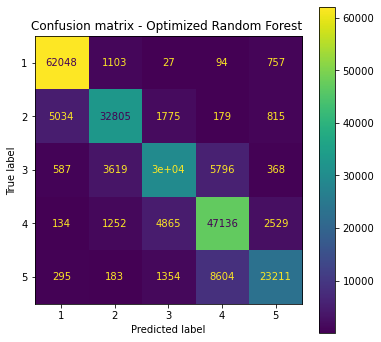

In [32]:
fig, ax = plt.subplots(figsize=(6, 6))
disp = plot_confusion_matrix(grid_search.best_estimator_, X, Y, display_labels=['1', '2', '3', '4', '5'], ax=ax)
disp.ax_.set_title('Confusion matrix - Optimized Random Forest ')

Text(0.5, 1.0, 'Feature Importance - Top 15')

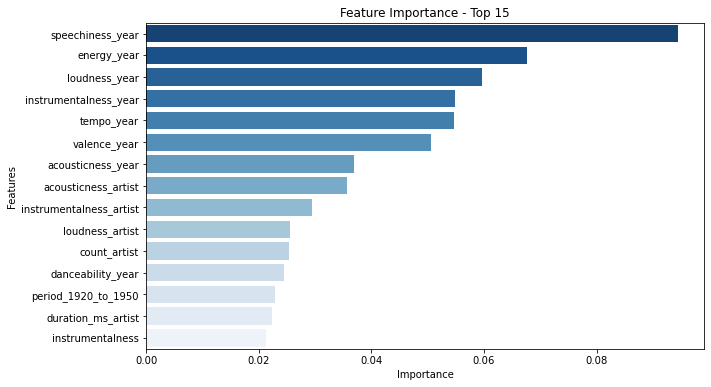

In [27]:
feature_importance = grid_search.best_estimator_.feature_importances_.tolist()
feature_name = X_test.columns.tolist()
rf_opt_fi_df = pd.DataFrame({'Features':feature_name, 'Importance':feature_importance}).sort_values(by='Importance',ascending=False)

plt.figure(figsize=(10,6))
ax = sns.barplot(x="Importance", y="Features", data=rf_opt_fi_df[0:15], palette='Blues_r')
plt.title('Feature Importance - Top 15')
# https://www.python-graph-gallery.com/101-make-a-color-palette-with-seaborn

XGBoost - Base

In [123]:
xgb_base_mod = xgb.XGBClassifier(objective="multi:softprob", 
                                 num_class = 5,
                                 seed = 72)

xgb_base_mod.fit(X_train, y_train)

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:09:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_class=5, num_parallel_tree=1,
              objective='multi:softprob', random_state=72, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=72, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [124]:
y_xgb_base_pred_train = xgb_base_mod.predict(X_train)
accuracy_score(y_train, y_xgb_base_pred_train, normalize=True)

0.7783808385958924

In [125]:
y_xgb_base_pred = xgb_base_mod.predict(X_test)
accuracy_score(y_test, y_xgb_base_pred, normalize=True)

0.7343061955965182

XGBoost - Optimal

In [141]:
xgb_mod1 = xgb.XGBClassifier(max_depth = 5, # should be between 3-10 
                             min_child_weight = 1, # smaller value for imbalanced
                             gamma = 0.005, # small value 0-0.2 --> min loss reduction required to make a further partition  #
                             subsample = 0.9, # 0.5-0.9
                             colsample_bytree = 0.9, # 0.5-0.9
                             learning_rate = 0.13,
                             n_estimators = 900,
                             objective = 'multi:softprob',
                             nthread = 4,
                             alpha = 0.9,
                             #scale_pos_weight = 1,
                             num_class = 5,
                             seed = 72)
xgb_mod1.fit(X_train, y_train)

[14:52:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(alpha=0.9, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.005, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.13, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=900, n_jobs=4, nthread=4, num_class=5,
              num_parallel_tree=1, objective='multi:softprob', random_state=72,
              reg_alpha=0.899999976, reg_lambda=1, scale_pos_weight=None,
              seed=72, subsample=0.9, tree_method='exact',
              validate_parameters=1, ...)

In [142]:
y_xgb_mod1_pred_train = xgb_mod1.predict(X_train)
accuracy_score(y_train, y_xgb_mod1_pred_train, normalize=True)
# 0.8293508562325766

0.8520566649598907

In [143]:
y_xgb_mod1_pred = xgb_mod1.predict(X_test)
accuracy_score(y_test, y_xgb_mod1_pred, normalize=True)
# 0.7532855436081243

0.7597712920293566

Result

In [46]:
xgb_mod1_fi = xgb_mod1.feature_importances_ # len = 49
xgb_mod1_fi_df = pd.DataFrame({'Features':X_test.columns.tolist(),'Importance':xgb_mod1_fi.tolist()}).sort_values(by='Importance', ascending=False)

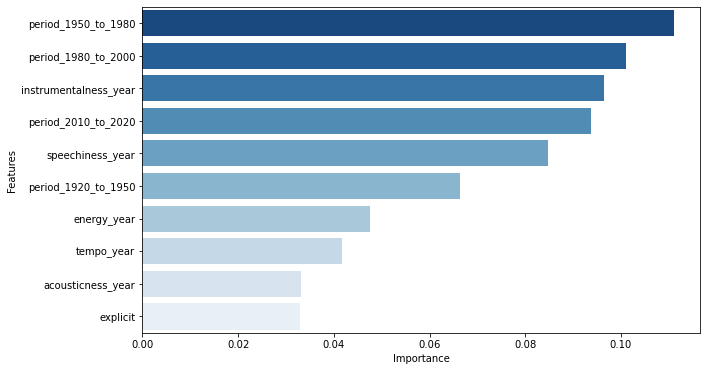

In [47]:
plt.figure(figsize=(10,6))
#sns.color_palette("Blues_d", as_cmap=True)
ax = sns.barplot(x="Importance", y="Features", data=xgb_mod1_fi_df[0:10], palette='Blues_r')

In [48]:
print(confusion_matrix(y_test, y_xgb_mod1_pred))
print('\n')
print(classification_report(y_test, y_xgb_mod1_pred))

[[15172   599     9    33   194]
 [ 1474  7585   809    79   205]
 [  117  1348  5963  2522    90]
 [   47   361  2237 10433   901]
 [  136    83   343  2512  5338]]


              precision    recall  f1-score   support

           1       0.90      0.95      0.92     16007
           2       0.76      0.75      0.75     10152
           3       0.64      0.59      0.61     10040
           4       0.67      0.75      0.71     13979
           5       0.79      0.63      0.71      8412

    accuracy                           0.76     58590
   macro avg       0.75      0.73      0.74     58590
weighted avg       0.76      0.76      0.76     58590



Text(0.5, 1.0, 'Confusion matrix - Optimized XGBoost ')

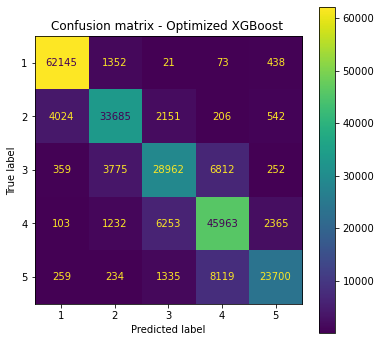

In [49]:
fig, ax = plt.subplots(figsize=(6, 6))
disp = plot_confusion_matrix(xgb_mod1, X, Y, display_labels=['1', '2', '3', '4', '5'], ax=ax)
disp.ax_.set_title('Confusion matrix - Optimized XGBoost ')

In [ ]:
y_xgb_mod1_pred_train = xgb_mod1.predict(X_train)
accuracy_score(y_train, y_xgb_mod1_pred_train, normalize=True)

--------

### Ensemble

In [50]:
reg_train_data = pd.read_csv('train_output_regression.csv')
reg_test_data = pd.read_csv('test_output_regression.csv')

[reg_train_data.shape, reg_test_data.shape]

[(175770, 51), (58590, 51)]

In [179]:
reg_train_y_pred = reg_train_data['popularity_group']
reg_test_y_pred = reg_test_data['popularity_group']

rf_train_y_pred = grid_search.best_estimator_.predict(X_train)
rf_test_y_pred = grid_search.best_estimator_.predict(X_test)
rf_all_y_pred = grid_search.best_estimator_.predict(X)

xgb_train_y_pred = xgb_mod1.predict(X_train)
xgb_test_y_pred = xgb_mod1.predict(X_test)
xgb_all_y_pred = xgb_mod1.predict(X)

In [183]:
all_train_ys = pd.DataFrame({'train_y': y_train.tolist(),
                             'reg_train_y': reg_train_y_pred.tolist(),
                             'rf_train_y': rf_train_y_pred.tolist(),
                             'xgb_train_y': xgb_train_y_pred.tolist()})

all_test_ys = pd.DataFrame({'test_y': y_test.tolist(),
                            'reg_test_y': reg_test_y_pred.tolist(),
                            'rf_test_y': rf_test_y_pred.tolist(),
                            'xgb_test_y': xgb_test_y_pred.tolist()})

In [184]:
print(confusion_matrix(all_train_ys['train_y'], all_train_ys['reg_train_y']))
print('\n')
print(classification_report(all_train_ys['train_y'], all_train_ys['reg_train_y']))

[[    0     0     0     0     0     0     0]
 [   48 37325  7990  2058   585    16     0]
 [    2  5858 15171  8590   799    36     0]
 [    0   325  3411 12340 14019    25     0]
 [    0    26   655  5403 34456  1396     1]
 [    0     7   352  2599 15797  6457    23]
 [    0     0     0     0     0     0     0]]




C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.86      0.78      0.82     48022
           2       0.55      0.50      0.52     30456
           3       0.40      0.41      0.40     30120
           4       0.52      0.82      0.64     41937
           5       0.81      0.26      0.39     25235
           6       0.00      0.00      0.00         0

    accuracy                           0.60    175770
   macro avg       0.45      0.39      0.40    175770
weighted avg       0.64      0.60      0.59    175770



Weighted Group

In [193]:
# average
#all_train_ys['ensemble_train_y'] = round((all_train_ys['reg_train_y']+all_train_ys['rf_train_y']+all_train_ys['xgb_train_y'])/3,0).astype(int)
#all_test_ys['ensemble_test_y'] = round((all_test_ys['reg_test_y']+all_test_ys['rf_test_y']+all_test_ys['xgb_test_y'])/3,0).astype(int)


# median
#all_train_ys['ensemble_train_y'] = all_train_ys[['reg_train_y','rf_train_y','xgb_train_y']].median(axis=1).astype(int)
#all_test_ys['ensemble_test_y'] = all_test_ys[['reg_test_y','rf_test_y','xgb_test_y']].median(axis=1).astype(int)


# weighted average
#all_train_ys['ensemble_train_y'] = round((all_train_ys['reg_train_y']+all_train_ys['rf_train_y']+all_train_ys['xgb_train_y'])/3,0).astype(int)
#all_test_ys['ensemble_test_y'] = all_test_ys['reg_test_y','rf_test_y','xgb_test_y'].mean(axis=1).astype(int)


# most frequent
def prefer_high_freq(row, rf_y, xgb_y):
    
    y_list = [row[rf_y], row[xgb_y]]
    
    if len(set(y_list)) < len(y_list):
        output = max(set(y_list), key = y_list.count) 
    else:
        output = int(round((sum(y_list) / len(y_list)),0))
        
    return output

#all_train_ys['ensemble_train_y'] = round(all_train_ys.apply(lambda row: prefer_high_freq(row,'rf_train_y','xgb_train_y'),axis=1))
#all_test_ys['ensemble_test_y'] = round(all_test_ys.apply(lambda row: prefer_high_freq(row,'rf_test_y','xgb_test_y'), axis=1))


# Preferred 3&4
def prefer34(row, rf_y, xgb_y):
    if any([row[rf_y]==4, row[xgb_y]==4]):
        output = 4
    elif any([row[rf_y]==3, row[xgb_y]==3]):
        output = 3
    else:
        output = round((row[rf_y]+row[xgb_y])/3,0).astype(int)
    return output
all_train_ys['ensemble_train_y'] = all_train_ys.apply(lambda row: prefer34(row,'rf_train_y','xgb_train_y'), axis = 1) 
all_test_ys['ensemble_test_y'] = all_test_ys.apply(lambda row: prefer34(row,'rf_test_y','xgb_test_y'), axis = 1) 

In [207]:
print(confusion_matrix(all_train_ys['train_y'], all_train_ys['rf_train_y']))
print('\n')
print(classification_report(all_train_ys['train_y'], all_train_ys['rf_train_y']))

[[46629   709    15    85   584]
 [ 3938 24457  1236   119   706]
 [  458  2804 21620  4930   308]
 [  104  1013  3485 35393  1942]
 [  190   133   968  7165 16779]]


              precision    recall  f1-score   support

           1       0.91      0.97      0.94     48022
           2       0.84      0.80      0.82     30456
           3       0.79      0.72      0.75     30120
           4       0.74      0.84      0.79     41937
           5       0.83      0.66      0.74     25235

    accuracy                           0.82    175770
   macro avg       0.82      0.80      0.81    175770
weighted avg       0.82      0.82      0.82    175770



In [195]:
print(confusion_matrix(all_test_ys['test_y'], all_test_ys['ensemble_test_y']))
print('\n')
print(classification_report(all_test_ys['test_y'], all_test_ys['ensemble_test_y']))

[[15611   182   170    44     0]
 [ 8816   125  1126    85     0]
 [ 1262    18  5586  3174     0]
 [  319    22  2352 11286     0]
 [  134   152  5232  2894     0]]


              precision    recall  f1-score   support

           1       0.60      0.98      0.74     16007
           2       0.25      0.01      0.02     10152
           3       0.39      0.56      0.46     10040
           4       0.65      0.81      0.72     13979
           5       0.00      0.00      0.00      8412

    accuracy                           0.56     58590
   macro avg       0.38      0.47      0.39     58590
weighted avg       0.43      0.56      0.46     58590



Train Results

In [136]:
print(confusion_matrix(all_train_ys['train_y'], all_train_ys['ensemble_train_y']))
print('\n')
print(classification_report(all_train_ys['train_y'], all_train_ys['ensemble_train_y']))

[[44576   761  2076   602     7]
 [ 3118 17779  8645   890    24]
 [  232  1127 14474 14266    21]
 [   35   328  2131 39068   375]
 [   38    49  2523 16367  6258]]


              precision    recall  f1-score   support

           1       0.93      0.93      0.93     48022
           2       0.89      0.58      0.70     30456
           3       0.48      0.48      0.48     30120
           4       0.55      0.93      0.69     41937
           5       0.94      0.25      0.39     25235

    accuracy                           0.69    175770
   macro avg       0.76      0.63      0.64    175770
weighted avg       0.76      0.69      0.68    175770



Text(0.5, 1.0, 'Confusion matrix - Optimized Random Forest ')

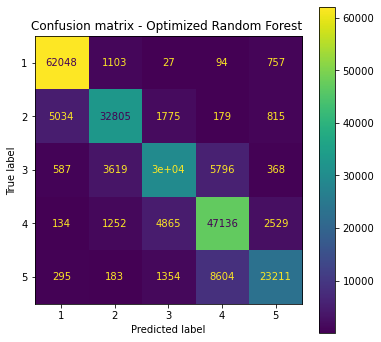

In [97]:
fig, ax = plt.subplots(figsize=(6, 6))
disp = plot_confusion_matrix(grid_search.best_estimator_, X, Y, display_labels=['1', '2', '3', '4', '5'], ax=ax)
disp.ax_.set_title('Confusion matrix - Optimized Random Forest ')

Test Results

In [137]:
print(confusion_matrix(all_test_ys['test_y'], all_test_ys['ensemble_test_y']))
print('\n')
print(classification_report(all_test_ys['test_y'], all_test_ys['ensemble_test_y']))

[[14520   533   710   239     5]
 [ 1564  5275  2983   314    16]
 [  105   624  4291  5011     9]
 [   24   131  1174 12410   240]
 [   54    28   812  5523  1995]]


              precision    recall  f1-score   support

           1       0.89      0.91      0.90     16007
           2       0.80      0.52      0.63     10152
           3       0.43      0.43      0.43     10040
           4       0.53      0.89      0.66     13979
           5       0.88      0.24      0.37      8412

    accuracy                           0.66     58590
   macro avg       0.71      0.60      0.60     58590
weighted avg       0.71      0.66      0.64     58590



Overall Results

In [203]:
all_ys_df = pd.DataFrame({'all_y':Y.tolist(), 'all_rf_pred':rf_all_y_pred.tolist(), 'all_xgb_pred':xgb_all_y_pred.tolist()})

all_ys_df['all_ensemble_pred'] = all_ys_df.apply(lambda row: prefer_high_freq(row,'all_rf_pred','all_xgb_pred'), axis = 1) 

In [210]:
print(confusion_matrix(all_ys_df['all_y'], all_ys_df['all_ensemble_pred']))
print('\n')
print(classification_report(all_ys_df['all_y'], all_ys_df['all_ensemble_pred']))

[[61193  1810   556   117   353]
 [ 3647 34278  1572   629   482]
 [  303  5166 25054  9422   215]
 [   65  1434  4299 48249  1869]
 [  135   222  1268 10588 21434]]


              precision    recall  f1-score   support

           1       0.94      0.96      0.95     64029
           2       0.80      0.84      0.82     40608
           3       0.77      0.62      0.69     40160
           4       0.70      0.86      0.77     55916
           5       0.88      0.64      0.74     33647

    accuracy                           0.81    234360
   macro avg       0.82      0.78      0.79    234360
weighted avg       0.82      0.81      0.81    234360



In [211]:
(88-82)/82

0.07317073170731707

In [ ]:
def prefer_high_freq(row, reg_y, rf_y, xgb_y):
    
    y_list = [row[reg_y], row[rf_y], row[xgb_y]]
    
    if len(set(y_list)) < len(y_list):
        output = max(set(y_list), key = y_list.count) 
    else:
        output = int(round((sum(y_list) / len(y_list)),0))
        
    return output

In [ ]:
def prefer34(row, reg_y, rf_y, xgb_y):
    if any([row[reg_y]==4, row[rf_y]==4, row[xgb_y]==4]):
        output = 4
    elif any([row[reg_y]==3, row[rf_y]==3, row[xgb_y]==3]):
        output = 3
    else:
        output = round((row[reg_y]+row[rf_y]+row[xgb_y])/3,0).astype(int)
    return output

- Tuning Order:
    - max_depth & min_child_weight
    - gamma
    - subsample & colsample_bytree
    - regularization parameters ('reg_alpha':[0, 0.001, 0.005, 0.01, 0.05])
    - reducing Learning rate (learning_rate)

In [27]:
xgb_param_grid1 = {
    'max_depth' : [7, 9],
    'min_child_weight' : [1, 3]
    }

xgb_opt_mod1 = xgb.XGBClassifier(#max_depth = 5, # should be between 3-10
                                 #min_child_weight = 3, # smaller value for imbalanced
                                 gamma = 0.1, # small value 0-0.2
                                 subsample = 0.8, # 0.5-0.9
                                 colsample_bytree = 0.8, # 0.5-0.9
                                 learning_rate = 0.1, 
                                 n_estimators = 500,
                                 objective = 'multi:softprob',
                                 nthread = 4,
                                 #scale_pos_weight = 1,
                                 num_class = 5,
                                 seed = 72)

xgb_grid_search = GridSearchCV(estimator = xgb_opt_mod1,
                               param_grid = xgb_param_grid1,
                               scoring = 'accuracy',
                               cv = 3,
                               n_jobs=4,
                               verbose = 0,
                               return_train_score = True)

xgb_grid_search.fit(X_train, y_train)

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:37:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0.1,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=500, n_jobs=None, nthread=4,
                                     num_class=5, num_parallel_tree=None,
                                     objective='multi:softprob',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_p

In [21]:
# Run #1: 
# 'max_depth' : [3, 5]
# 'min_child_weight' : [5, 8, 10]
# best_params: {'max_depth': 5, 'min_child_weight': 5}

# Run #2: 
# 'max_depth' : [5, 7]
# 'min_child_weight' : [3, 5, 6]
# best_params: {'max_depth': 7, 'min_child_weight': 3}

# Run #3: 
# 'max_depth' : [7, 9]
# 'min_child_weight' : [1, 3]
# best_params: {'max_depth': 9, 'min_child_weight': 1}

In [ ]:
xgb_grid_search_result1 = [xgb_grid_search.grid_scores_, xgb_grid_search.best_params_, xgb_grid_search.best_score_]

In [28]:
xgb_grid_search.best_params_

{'max_depth': 9, 'min_child_weight': 1}

In [29]:
y_xgb_gs_pred_train = xgb_grid_search.best_estimator_.predict(X_train)
accuracy_score(y_train, y_xgb_gs_pred_train, normalize=True)

0.977442111850714

In [30]:
y_xgb_gs_pred = xgb_grid_search.best_estimator_.predict(X_test)
accuracy_score(y_test, y_xgb_gs_pred, normalize=True)

0.7833930704898446

In [112]:
def modelfit(alg, dtrain, predictors, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')